In [124]:
from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.potential.mwpotentials import McMillan17
import numpy as np
import matplotlib.pyplot as plt

from stream_package.stream_package import graphics

In [132]:
# Integration of galaxies:
tdisrupt=10

ro = conversion.get_physical(McMillan17)['ro']
vo = conversion.get_physical(McMillan17)['vo']
to = conversion.time_in_Gyr(ro=ro, vo=vo)
mo = conversion.mass_in_msol(ro=ro, vo=vo)
ts = np.linspace(0, -tdisrupt/to, 1001)

pot = McMillan17

o_sats = Orbit.from_name('MW satellite galaxies', ro=ro, vo=vo)
o_sats.integrate(ts, pot)

In [133]:
mass_lmc=1.38e11 #solar masses
rscale_lmc=10.2 #kpc

pot = McMillan17

#Initialize and integrate the orbit of the LMC
#Note orbit has to be integrated back 5 Gyr
#Note we assume the LMC experienced dynamical friction due to MW
o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot[1], ro=ro,vo=vo)
o_lmc.integrate(ts,pot+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot_lmc = MovingObjectPotential(o_lmc, pot_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]

In [134]:
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                use_physical=False)

t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

In [135]:
o_sats_LMC = Orbit.from_name('MW satellite galaxies', ro=ro, vo=vo)
o_sats_LMC.integrate(ts, pot + moving_pot_lmc + nip)

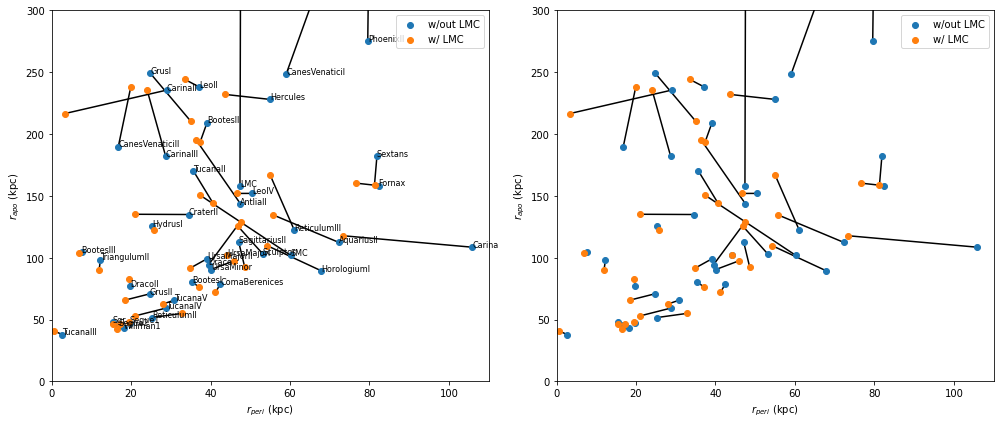

In [136]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.array([o_sats.rperi(), o_sats_LMC.rperi()])
y = np.array([o_sats.rap(), o_sats_LMC.rap()])

ax1.scatter(o_sats.rperi(), o_sats.rap(), label='w/out LMC')
ax1.scatter(o_sats_LMC.rperi(), o_sats_LMC.rap(), label='w/ LMC')
ax1.plot(x, y, c='k', zorder=0);

ax2.scatter(o_sats.rperi(), o_sats.rap(), label='w/out LMC')
ax2.scatter(o_sats_LMC.rperi(), o_sats_LMC.rap(), label='w/ LMC')
ax2.plot(x, y, c='k', zorder=0);

for i in range(len(o_sats.rperi())):
    name = o_sats.name[i]
    xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
    ax1.annotate(name, (xname,yname), size=8)

ax1.set_xlim(0,110)
ax1.set_ylim(0,300)
ax1.legend()
ax1.set_xlabel('$r_{peri}$ (kpc)', size=10)
ax1.set_ylabel('$r_{apo}$ (kpc)', size=10)

ax2.set_xlim(0,110)
ax2.set_ylim(0,300)
ax2.legend()
ax2.set_xlabel('$r_{peri}$ (kpc)', size=10)
ax2.set_ylabel('$r_{apo}$ (kpc)', size=10)
plt.tight_layout()

In [137]:
#indx = 0.75 < np.divide(o_sats.rperi(),o_sats_LMC.rperi()) or np.divide(o_sats.rap(),o_sats_LMC.rap()) > 1.25
indx1 = np.where(1.25 < np.divide(o_sats.rperi(),o_sats_LMC.rperi()), True, False)
indx2 = np.where(0.75 > np.divide(o_sats.rperi(),o_sats_LMC.rperi()), True, False)
indx3 = np.where(1.25 < np.divide(o_sats.rap(),o_sats_LMC.rap()), True, False)
indx4 = np.where(0.75 > np.divide(o_sats.rap(),o_sats_LMC.rap()), True, False)
indx = indx1 + indx2 + indx3 + indx4


Text(0.5, 1.0, 'Orbital pericentre/apocentre comparison with large (>25%) change')

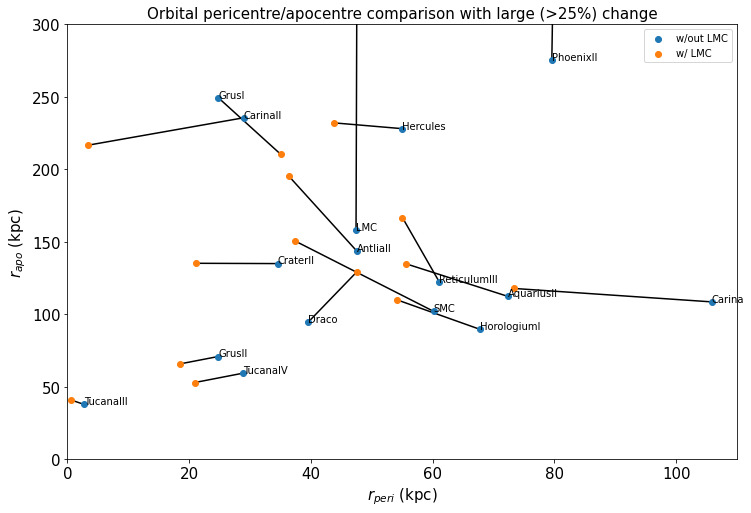

In [138]:
fig = plt.figure(figsize=(12,8))

x = np.array([o_sats.rperi(), o_sats_LMC.rperi()])
y = np.array([o_sats.rap(), o_sats_LMC.rap()])

plt.scatter(o_sats.rperi()[indx], o_sats.rap()[indx], label='w/out LMC')
plt.scatter(o_sats_LMC.rperi()[indx], o_sats_LMC.rap()[indx], label='w/ LMC')
plt.plot(x[:,indx], y[:,indx], c='k', zorder=0);

for i in range(len(o_sats.rperi())):
    if i in np.arange(50)[indx]:
        name = o_sats.name[i]
        xname, yname = o_sats.rperi()[i], o_sats.rap()[i]
        plt.annotate(name, (xname,yname))

plt.xlim(0,110)
plt.ylim(0,300)
plt.legend()
plt.xlabel('$r_{peri}$ (kpc)', size=15)
plt.ylabel('$r_{apo}$ (kpc)', size=15)
plt.xticks(size=15)
plt.yticks(size=15);
plt.title('Orbital pericentre/apocentre comparison with large (>25%) change', size=15)